In [15]:
import tensorflow as tf
from keras.applications import ResNet50
from keras.models import Model
from keras import models
from keras import layers
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

In [16]:
input_folder = './ASL_unique'
output_folder = './sorted_ResNet50uniqueOpti'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))


target_size = (200, 200)


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    output_folder + '/train',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    output_folder + '/val',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Copying files: 39956 files [00:01, 32765.09 files/s]


Found 31962 images belonging to 8 classes.
Found 7994 images belonging to 8 classes.


In [17]:
input_folder = './ASL_test'


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    input_folder,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

Found 7200 images belonging to 8 classes.


Epoch 1/25
999/999 [==============================] - 343s 336ms/step - loss: 0.1474 - accuracy: 0.9549 - val_loss: 0.2329 - val_accuracy: 0.9507
Epoch 2/25
999/999 [==============================] - 352s 353ms/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.0058 - val_accuracy: 0.9982
Epoch 3/25
999/999 [==============================] - 362s 362ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9987
Epoch 4/25
999/999 [==============================] - 372s 372ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0035 - val_accuracy: 0.9991
Epoch 5/25
999/999 [==============================] - 363s 363ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0029 - val_accuracy: 0.9992
Epoch 6/25
999/999 [==============================] - 351s 351ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0034 - val_accuracy: 0.9991
Epoch 7/25
999/999 [==============================] - 348s 349ms/step - loss: 8.7726e-04 - accuracy: 1.0000 - val_loss: 0.00

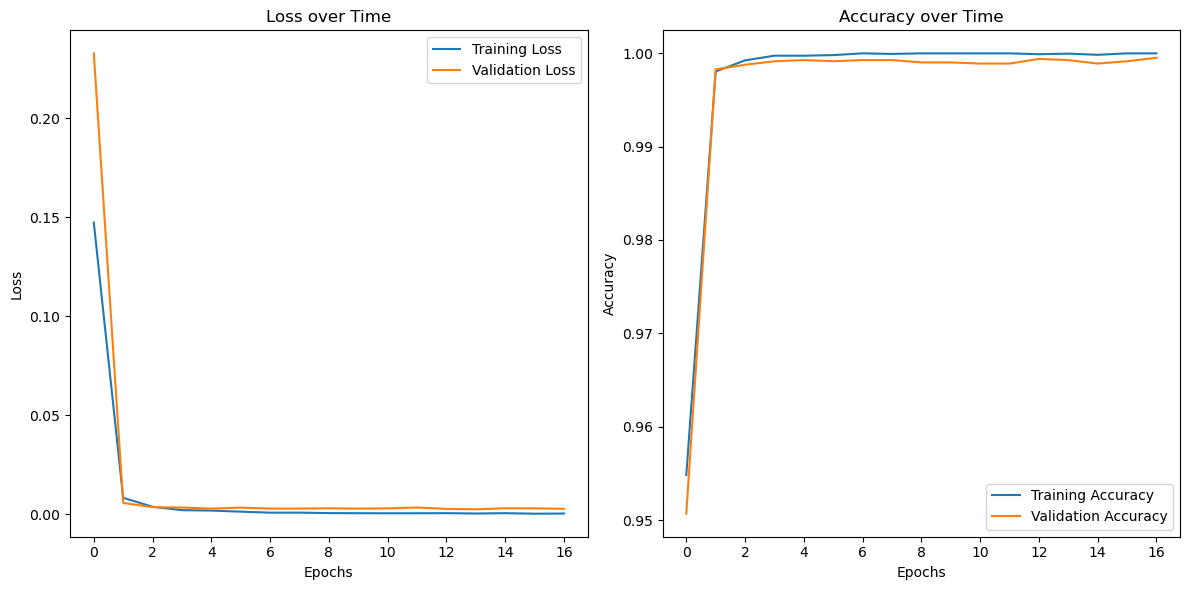

In [18]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Schritt 2: Fügen Sie dem ResNet-50-Modell einen benutzerdefinierten Klassifikator hinzu
x = layers.Flatten()(resnet_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(8, activation='softmax')(x)  

model_resnet = models.Model(inputs=resnet_model.input, outputs=output)

# Schritt 3: Kompilieren Sie das Modell
model_resnet.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Schritt 4: Frühzeitiges Stoppen einrichten
early_stop_resnet = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Schritt 5: Trainieren Sie das Modell und speichern Sie die Historie
history_resnet = model_resnet.fit(train_generator, epochs=25, validation_data=val_generator, callbacks=[early_stop_resnet])

# Schritt 6: Model Summary anzeigen
model_resnet.summary()

# Schritt 7: Testen Sie das Modell und bewerten Sie es auf dem Testset
loss_resnet, accuracy_resnet = model_resnet.evaluate(test_generator)
print(f'Test loss (ResNet-50): {loss_resnet}')
print(f'Test accuracy (ResNet-50): {accuracy_resnet}')

# Schritt 8: Plot Loss und Accuracy über die Zeit
plt.figure(figsize=(12, 6))

# Plot Loss über die Zeit
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy über die Zeit
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

save_directory = './Result'
os.makedirs(save_directory, exist_ok=True)

for _ in range(1):
    predictions = model_resnet.predict(test_generator)
    
    true_labels = test_generator.labels
    incorrect_indices = np.where(np.argmax(predictions, axis=1) != true_labels)[0]

    for i in range(len(incorrect_indices)):
        batch_index = incorrect_indices[i] // test_generator.batch_size
        in_batch_index = incorrect_indices[i] % test_generator.batch_size

        image = test_generator[batch_index][0][in_batch_index]
        true_label = true_labels[incorrect_indices[i]]
        predicted_label = np.argmax(predictions[incorrect_indices[i]])

        # Display the image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')

        # Save the image to the specified directory
        image_filename = f'incorrect_image_{i+1}_true_{true_label}_pred_{predicted_label}.png'
        image_path = os.path.join(save_directory, image_filename)
        plt.savefig(image_path)

        # Close the plot to avoid displaying it
        plt.close()


225/225 [==============================] - 37s 163ms/step


In [ ]:
print("Class indices in test_generator:", test_generator.class_indices)

Class indices in test_generator: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}


In [ ]:
print("Shape of test_generator.labels:", test_generator.labels.shape)
print("Sample labels from test_generator:", test_generator.labels[898:2000])

Shape of test_generator.labels: (7200,)
Sample labels from test_generator: [0 0 1 ... 2 2 2]
